<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [1]:
!pip install faiss-cpu #faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 64.2 MB/s eta 0:00:00


In [2]:
!pip install -q gdown torch transformers==4.49 accelerate bitsandbytes langchain sentence-transformers openpyxl datasets langchain-community ragatouille umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 789.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

/tmp/ipython-input-3-3493547684.py:18: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


## Загрузка данных (4 балла)

In [4]:
# Берём данные с коллаба
from google.colab import drive

BASE_FOLDER = '/content/gdrive'

drive.mount(BASE_FOLDER)

Mounted at /content/gdrive


In [5]:
data = pd.read_csv(
    '/content/gdrive/MyDrive/RAG/file.csv'
)

In [6]:
'''
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')
'''

"\nurl = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'\noutput = 'file.csv'\n\ngdown.download(url, output, quiet=False)\n\ndata = pd.read_csv('file.csv')\n"

In [7]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [8]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [9]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

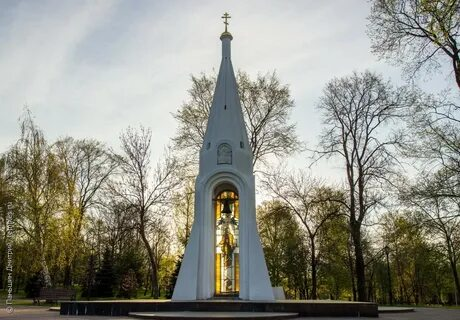

In [10]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

Очистка датасета

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
corpus_en = data['en_txt']

In [13]:
v = TfidfVectorizer()
x = v.fit_transform(corpus_en)

In [14]:
x_array = x.toarray()

In [15]:
temp = np.where(x_array > 0.9, 1, 0)

In [16]:
print(temp.any(axis = 1).shape)

(14634,)


In [17]:
data = data[temp.any(axis = 1) == False]

In [18]:
data_dropped = data.drop_duplicates(subset = ['Name', 'City'])

In [19]:
data_dropped.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
41,41,№32 Дом обороны,Q55209768,Екатеринбург,60.601315,56.834167,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large building with a helicopter on...
68,68,Дом обороны,Q55209768,Екатеринбург,60.602409,56.835133,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large building with a helicopter on...
97,97,№28 Здание городской электростанции «Луч»,Q55154121,Екатеринбург,60.607430,56.833691,здание и достопримечательность в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a bridge that is going over a river w...
123,123,№27 Дом Г.Н. Скрябина,Q55232375,Екатеринбург,60.607075,56.834225,Дом Е.Д. Скрябиной,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars parked in front of a building with a cloc...


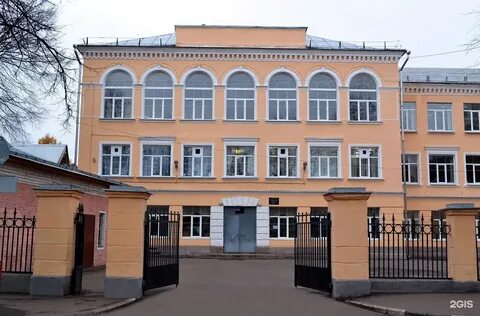

In [20]:
get_image(data_dropped.sample(1)['image'].tolist()[0])

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [21]:
print(data_dropped)

       Unnamed: 0                                               Name  \
0               0                                             Динамо   
41             41                                    №32 Дом обороны   
68             68                                        Дом обороны   
97             97          №28 Здание городской электростанции «Луч»   
123           123                              №27 Дом Г.Н. Скрябина   
...           ...                                                ...   
14433        4171                         Ярославский камерный театр   
14461        4199                       Ярославский музей-заповедник   
14488        4226  Ярославский филиал Военно-космической академии...   
14548        4286  Ярославский художественный музей (Губернаторск...   
14607        4345                 Ярославское художественное училище   

        WikiData          City        Lon        Lat  \
0      Q37996725  Екатеринбург  60.600349  56.845398   
41     Q55209768  Екате

In [22]:
pd.set_option("display.max_colwidth", None)

In [23]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["en_txt"], metadata={"image": doc["image"]}) for _, doc in tqdm(data_dropped.iterrows(), total = data_dropped.shape[0])
]

  0%|          | 0/391 [00:00<?, ?it/s]

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Разобъём документы на блоки максимального размера `chunk_size` и вернём список документов.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Удалим дубли
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/354 [00:00<?, ?it/s]

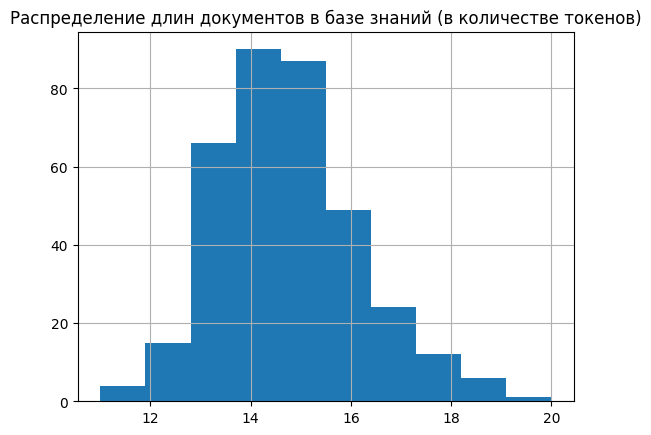

In [25]:
docs_processed = split_documents(
    128,  # Выбираем размер чанка, соответствующий модели
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Представим размеры блоков, которые возможно получить в токенах из общей модели
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [29]:
# your code here
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    #model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # `True` для косинусного сходства
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [30]:
# Вставляем пользовательский запрос в то же пространство
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [28]:
!pip install pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=551736 sha256=2d4107ebaa5b17c5625e400e4c85839e7ced95813a9c9aba1cc57d1a0f0285bf
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [31]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [32]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["image"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализируем эмбеддинги
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PaCMAP</b>",
)
fig.show()

In [33]:
# Вставляем пользовательский запрос в то же пространство
user_query = "I want to see helicopter inside bulding"
#query_vector = embedding_model.embed_query(user_query)


Starting retrieval for user_query='I want to see helicopter inside bulding'...

==================================Top document==================================
there is a large building with a helicopter on top of it
==================================Metadata==================================


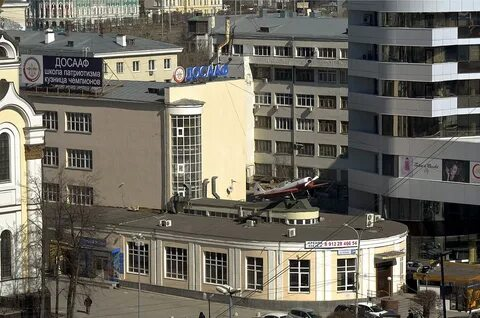

In [34]:
# your code here
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
get_image(retrieved_docs[0].metadata['image'])
#print(retrieved_docs[0].metadata)

In [35]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

In [39]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give me information based on context.
Response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give me information based on context.
Response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Based on Document 4, which provides an aerial view of a large green and white building with a yellow dome, we can describe the building as follows:
- The building has a predominantly green and white exterior.
- It has a distinctive yellow dome on its roof.
- From the aerial view provided, it appears to be a large structure.
- There is no further detail given about the style or architecture of the building.

Additional information may be available from other sources, but this description is based solely on the context provided in Document 4.
******************************


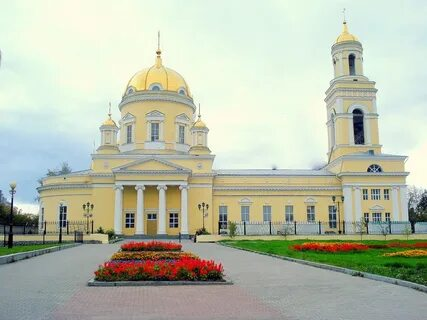

In [48]:
question = "Can you give me detailed description of a yellow building"
final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)
print('*' * 30)
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=question, k=5)
get_image(retrieved_docs[0].metadata['image'])